In [24]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers, models

In [2]:
tf.__version__

'2.14.0'

In [132]:
import os

gpu_memory = os.popen('nvidia-smi --query-gpu=memory.used --format=csv,nounits,noheader').read().strip()
print("GPU Memory Usage (MB):", gpu_memory)

GPU Memory Usage (MB): 3


In [133]:

(train_images, train_labels), (val_images, val_labels) = tf.keras.datasets.mnist.load_data()

train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)

train_images = train_images.astype('float32')/255.0
val_images = val_images.astype('float32')/255.0

train_images = tf.image.grayscale_to_rgb(tf.image.resize(train_images, (32,32)))
val_images = tf.image.grayscale_to_rgb(tf.image.resize(val_images, (32,32)))

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
val_labels = tf.keras.utils.to_categorical(val_labels, 10)

def data_generator(images, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.cache()
    dataset = dataset.shuffle(20000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = data_generator(train_images, train_labels)
val_dataset = data_generator(val_images, val_labels)

In [134]:
print(f'1. train_labels :{train_labels.shape}, val_labels : {val_labels.shape}')

1. train_labels :(60000, 10), val_labels : (10000, 10)


(64, 32, 32, 3)
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
(64, 10)
Normalized values:  (0.0, 0.99215686)


2024-08-17 19:00:58.449817: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


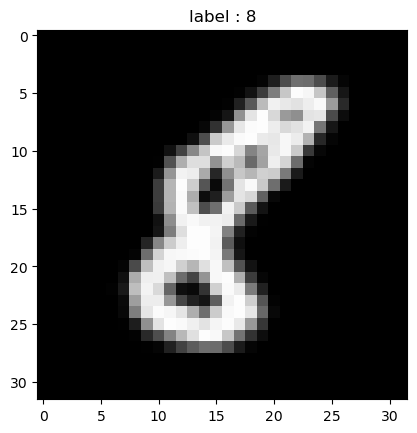

In [135]:
for img_batch, label_batch in train_dataset.take(1):
    print(img_batch.shape)
    print(type(img_batch.shape))
    print(label_batch.shape)
    img = np.array(img_batch)
    label = np.argmax(label_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])
    plt.title(f"label : {label}")

In [136]:

val_batches = tf.data.experimental.cardinality(val_dataset) #calcute no.of batches in val_set

test_dataset = val_dataset.take(val_batches // 10) #take the first 20% of the val set, and create a new test set
val_dataset = val_dataset.skip(val_batches // 10) #skip the first 20% of the data used for creating test set
batch_size = 32

print('number of val batches: %d' % val_batches)
print('number of images in val set :', len(val_dataset)*batch_size)
print('number of test batches :%d', tf.data.experimental.cardinality(test_dataset))
print('number of images in test_set:', len(test_dataset)*batch_size)

number of val batches: 157
number of images in val set : 4544
number of test batches :%d tf.Tensor(15, shape=(), dtype=int64)
number of images in test_set: 480


In [137]:
val_batches = tf.data.experimental.cardinality(val_dataset) #calcute no.of batches in val_set

test_dataset = val_dataset.take(val_batches // 10) #take the first 20% of the val set, and create a new test set
val_dataset = val_dataset.skip(val_batches // 10) #skip the first 20% of the data used for creating test set
batch_size = 32

print('number of val batches: %d' % val_batches)
print('number of images in val set :', len(val_dataset)*batch_size)
print('number of test batches :%d', tf.data.experimental.cardinality(test_dataset))
print('number of images in test_set:', len(test_dataset)*batch_size)

number of val batches: 142
number of images in val set : 4096
number of test batches :%d tf.Tensor(14, shape=(), dtype=int64)
number of images in test_set: 448


In [126]:
# import shutil
# # test_dataset.save('test_dataset')
# shutil.make_archive("test_dataset", "zip", "test_dataset")

'/home/s2310144/workshop/Underspecification/mnist/test_dataset.zip'

In [46]:
cnn_model = keras.Sequential(
    [
        keras.Input(shape=(32,32,3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

In [47]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2304)             

In [48]:
%%time
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

history = cnn_model.fit(train_dataset, batch_size=128, epochs=10,
                            validation_data=(val_dataset))

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.2327 - accuracy: 0.9280 - val_loss: 0.0605 - val_accuracy: 0.9802
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0845 - accuracy: 0.9745 - val_loss: 0.0417 - val_accuracy: 0.9865
Epoch 3/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0641 - accuracy: 0.9798 - val_loss: 0.0341 - val_accuracy: 0.9882
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0559 - accuracy: 0.9826 - val_loss: 0.0322 - val_accuracy: 0.9878
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0474 - accuracy: 0.9848 - val_loss: 0.0287 - val_accuracy: 0.9904
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0424 - accuracy: 0.9867 - val_loss: 0.0238 - val_accuracy: 0.9929
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0421 - accuracy: 0.9870 - val_loss: 0.0248 - val_accuracy: 0.9914
Epoch 

128/128 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9932
Validation accuracy: 0.9932


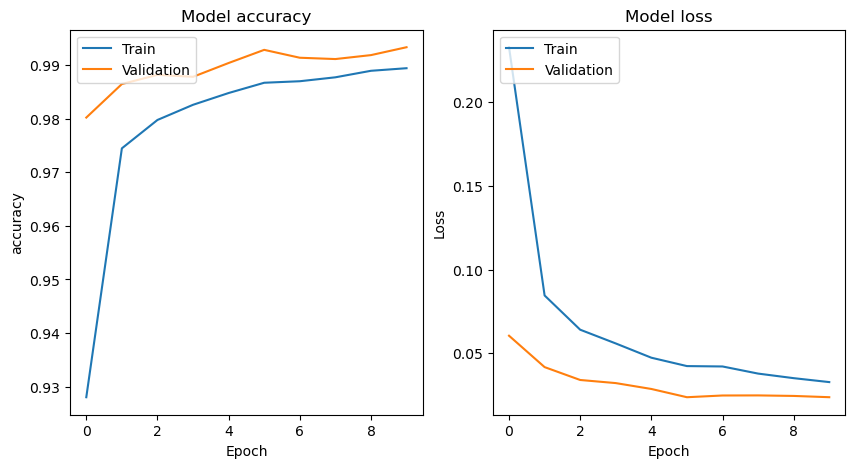

In [49]:
# Evaluate the model
val_loss, val_acc = cnn_model.evaluate(val_dataset)
print(f"Validation accuracy: {val_acc:.4f}")


plt.figure(figsize=(10,5))
#plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [28]:
#multi layer perceptron
mlp_model = models.Sequential([
    layers.Flatten(input_shape=(32,32,3)),
    layers.Dense(256, activation='relu'),

    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
] )

In [25]:
mlp_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               786688    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 10)               

In [29]:
mlp_model.compile(optimizer=('adam'),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_mlp = mlp_model.fit(train_dataset,
                            epochs=10,
                            validation_data=(val_dataset)
                            )

Epoch 1/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.2833 - accuracy: 0.9201 - val_loss: 0.1524 - val_accuracy: 0.9571
Epoch 2/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1480 - accuracy: 0.9598 - val_loss: 0.1205 - val_accuracy: 0.9665
Epoch 3/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1129 - accuracy: 0.9686 - val_loss: 0.1189 - val_accuracy: 0.9711
Epoch 4/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.0934 - accuracy: 0.9743 - val_loss: 0.1161 - val_accuracy: 0.9724
Epoch 5/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.0796 - accuracy: 0.9784 - val_loss: 0.1213 - val_accuracy: 0.9749
Epoch 6/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.0700 - accuracy: 0.9802 - val_loss: 0.1180 - val_accuracy: 0.9740
Epoch 7/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.0652 - accuracy: 0.9817 - val_loss: 0.1176 - val_ac

563/563 [==============================] - 1s 1ms/step - loss: 0.1244 - accuracy: 0.9779
Validation accuracy: 0.9779


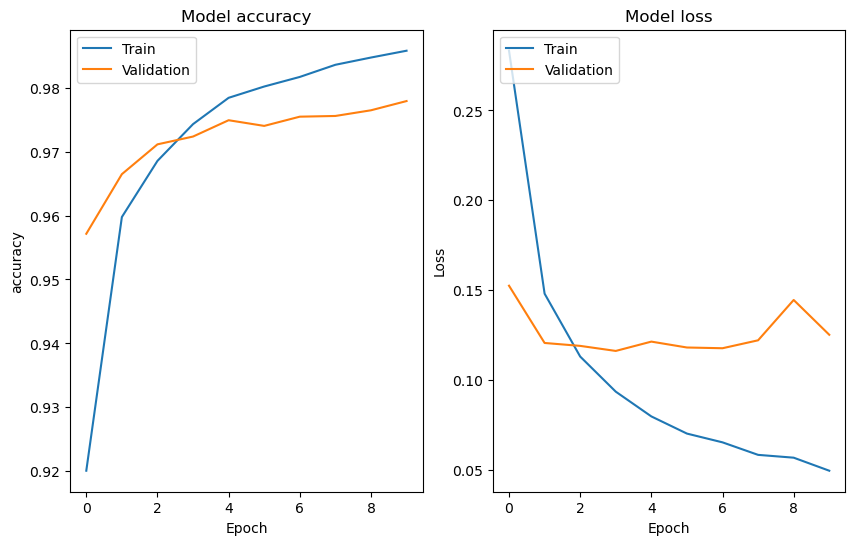

In [30]:
# Evaluate the mlp_model
val_loss_mlp, val_acc_mlp = mlp_model.evaluate(val_dataset)
print(f"Validation accuracy: {val_acc_mlp:.4f}")


plt.figure(figsize=(10,6))
#plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# cnn_model.save('models/std/cnn_mnist_std.h5')
# mlp_model.save('models/std/mlp_mnist_std.h5')

In [71]:
base_mobilenet = tf.keras.applications.MobileNetV2(weights=None,
                                                   include_top=False,
                                                   input_shape=(32, 32, 3))

#add fully connected layers
mobilenet_model= models.Sequential()

mobilenet_model.add(base_mobilenet)
mobilenet_model.add(layers.GlobalAveragePooling2D())

mobilenet_model.add(layers.Dense(256, activation='relu'))
mobilenet_model.add(layers.Dropout(0.4))
mobilenet_model.add(layers.Dense(10, activation='softmax'))

#train with MNIST
mobilenet_model.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

In [68]:
mobilenet_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_32 (Funct  (None, 1, 1, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 256)               327936    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 10)                2570      
                                                                 
Total params: 2588490 (9.87 MB)
Trainable params: 255

In [72]:
mobilenet_std = mobilenet_model.fit(train_dataset, 
                                        epochs=10, 
                                        validation_data=val_dataset)

Epoch 1/10
3750/3750 [==============================] - 218s 56ms/step - loss: 0.6120 - accuracy: 0.8298 - val_loss: 2.2953 - val_accuracy: 0.1716
Epoch 2/10
3750/3750 [==============================] - 212s 57ms/step - loss: 0.2564 - accuracy: 0.9446 - val_loss: 3.8313 - val_accuracy: 0.8368
Epoch 3/10
3750/3750 [==============================] - 216s 58ms/step - loss: 0.1863 - accuracy: 0.9609 - val_loss: 0.2764 - val_accuracy: 0.9657
Epoch 4/10
3750/3750 [==============================] - 216s 58ms/step - loss: 0.1543 - accuracy: 0.9682 - val_loss: 0.1832 - val_accuracy: 0.9742
Epoch 5/10
3750/3750 [==============================] - 215s 57ms/step - loss: 0.1193 - accuracy: 0.9748 - val_loss: 0.1182 - val_accuracy: 0.9792
Epoch 6/10
3750/3750 [==============================] - 211s 56ms/step - loss: 0.0951 - accuracy: 0.9787 - val_loss: 0.0657 - val_accuracy: 0.9858
Epoch 7/10
3750/3750 [==============================] - 213s 57ms/step - loss: 0.0859 - accuracy: 0.9806 - val_loss: 0

AttributeError: 'History' object has no attribute 'save'

Model saved as mobilenet_std.h5


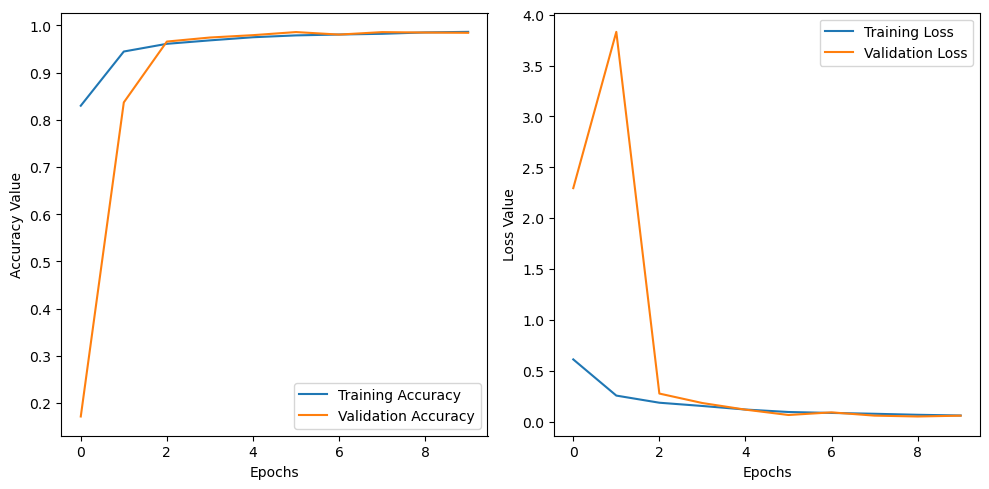

In [73]:
#save the model if accuracy thresholds are met
MN_std_train_acc = max(mobilenet_std.history['accuracy'])
MN_std_val_acc = max(mobilenet_std.history['val_accuracy'])

if MN_std_train_acc > 0.90 and MN_std_val_acc > 0.90:
    mobilenet_model.save('models/std/mobilenet_mnist_std.h5')
    print('Model saved as mobilenet_std.h5')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(mobilenet_std.history['accuracy'], label='Training Accuracy')
plt.plot(mobilenet_std.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mobilenet_std.history['loss'], label='Training Loss')
plt.plot(mobilenet_std.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
base_resnet = tf.keras.applications.ResNet50(weights= None,
                                             include_top=False,
                                             input_shape=(32, 32, 3))

#add fully connected layers
resnet_model= models.Sequential()

resnet_model.add(base_resnet)
resnet_model.add(layers.GlobalAveragePooling2D())

resnet_model.add(layers.Dense(256, activation='relu'))
resnet_model.add(layers.Dropout(0.4))
resnet_model.add(layers.Dense(10, activation='softmax'))

#train with MNIST
resnet_model.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

In [53]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24114826 (91.99 MB)
Trainable params: 24061706 (91.79 MB)
Non-trainable params: 53120 (207.50 KB)
________

Epoch 1/10
3750/3750 [==============================] - 289s 74ms/step - loss: 0.5189 - accuracy: 0.8645 - val_loss: 0.6676 - val_accuracy: 0.8217
Epoch 2/10
3750/3750 [==============================] - 275s 73ms/step - loss: 0.3184 - accuracy: 0.9243 - val_loss: 0.1459 - val_accuracy: 0.9649
Epoch 3/10
3750/3750 [==============================] - 275s 73ms/step - loss: 0.3010 - accuracy: 0.9249 - val_loss: 0.0934 - val_accuracy: 0.9776
Epoch 4/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.2137 - accuracy: 0.9477 - val_loss: 0.2944 - val_accuracy: 0.9274
Epoch 5/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.2105 - accuracy: 0.9476 - val_loss: 0.0649 - val_accuracy: 0.9822
Epoch 6/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.1147 - accuracy: 0.9746 - val_loss: 0.0475 - val_accuracy: 0.9875
Epoch 7/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.1018 - accuracy: 0.9766 - val_loss: 0

NameError: name 'resnetnet_std' is not defined

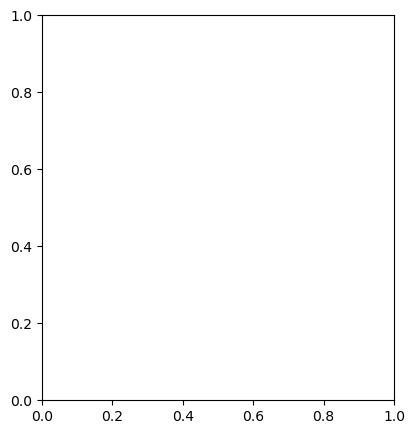

In [87]:
%%time
resnet_std = resnet_model.fit(train_dataset,
                            epochs=10, 
                            validation_data=val_dataset)

# Save the model if accuracy thresholds are met
resnet_std_train_acc = max(resnet_std.history['accuracy'])
resnet_std_val_acc = max(resnet_std.history['val_accuracy'])

if resnet_std_train_acc > 0.90 and resnet_std_val_acc > 0.90:
    resnet_model.save('models/std/resnet_mnist_std.h5')
    print('Model saved as resnet_std.h5')

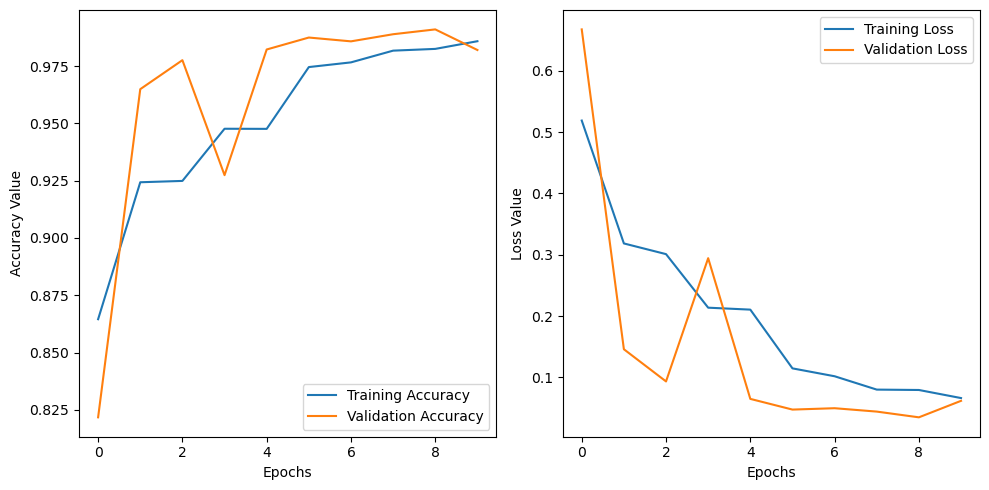

In [88]:
# Plot accuracy
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(resnet_std.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_std.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(resnet_std.history['loss'], label='Training Loss')
plt.plot(resnet_std.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
base_densenet = tf.keras.applications.DenseNet121(weights=None, 
                                                  include_top=False,
                                                  input_shape=(32, 32, 3))

#add fully connected layers
densenet_model= models.Sequential()

densenet_model.add(base_densenet)
densenet_model.add(layers.GlobalAveragePooling2D())

densenet_model.add(layers.Dense(256, activation='relu'))
densenet_model.add(layers.Dropout(0.4)),
densenet_model.add(layers.Dense(10, activation='softmax'))

#train with MNIST
densenet_model.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

In [60]:
densenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                2570      
                                                                 
Total params: 7302474 (27.86 MB)
Trainable params: 7218826 (27.54 MB)
Non-trainable params: 83648 (326.75 KB)
__________

Epoch 1/10
3750/3750 [==============================] - 523s 133ms/step - loss: 0.2083 - accuracy: 0.9438 - val_loss: 0.0728 - val_accuracy: 0.9776
Epoch 2/10
3750/3750 [==============================] - 496s 132ms/step - loss: 0.1141 - accuracy: 0.9705 - val_loss: 0.0513 - val_accuracy: 0.9859
Epoch 3/10
3750/3750 [==============================] - 495s 132ms/step - loss: 0.0835 - accuracy: 0.9792 - val_loss: 0.0477 - val_accuracy: 0.9872
Epoch 4/10
3750/3750 [==============================] - 495s 132ms/step - loss: 0.0701 - accuracy: 0.9820 - val_loss: 0.0320 - val_accuracy: 0.9908
Epoch 5/10
3750/3750 [==============================] - 493s 132ms/step - loss: 0.0556 - accuracy: 0.9858 - val_loss: 0.0251 - val_accuracy: 0.9925
Epoch 6/10
3750/3750 [==============================] - 494s 132ms/step - loss: 0.0467 - accuracy: 0.9876 - val_loss: 0.0309 - val_accuracy: 0.9910
Epoch 7/10
3750/3750 [==============================] - 493s 132ms/step - loss: 0.0448 - accuracy: 0.9889 - val_

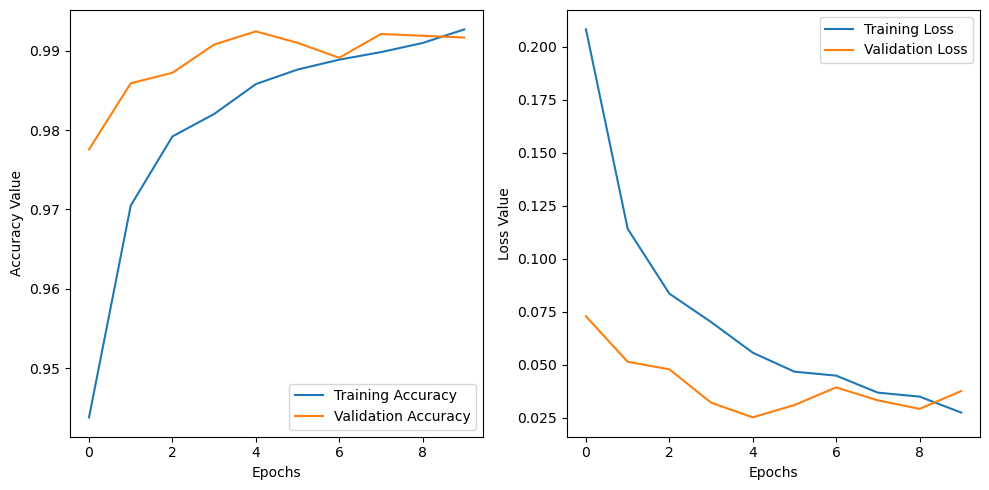

In [96]:
densenet_std = densenet_model.fit(train_dataset, 
                                 epochs=10, 
                                 validation_data=val_dataset)

# Save the model if accuracy thresholds are met
densenet_std_train_acc = max(densenet_std.history['accuracy'])
densenet_std_val_acc = max(densenet_std.history['val_accuracy'])

if densenet_std_train_acc > 0.90 and densenet_std_val_acc > 0.90:
    densenet_model.save('models/std/densenet_mnist_std.h5')
    print('Model saved as densenet_std.h5')

# Plot accuracy
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(densenet_std.history['accuracy'], label='Training Accuracy')
plt.plot(densenet_std.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(densenet_std.history['loss'], label='Training Loss')
plt.plot(densenet_std.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# Adversarial Training

In [50]:
from tqdm import tqdm

In [54]:
"""FGSM algorithm"""

def create_adversarial_pattern(model, image, label):
    # image = tf.convert_to_tensor(image) #should be avoided if the images are already in tensor format
    # label = tf.convert_to_tensor(label)
    with tf.GradientTape() as tape:#creates a tf.GradientTape object, which is used to record the gradients of the loss function with respect to the input image.
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

"For adversarial training"
def adv_training(model, epochs, epsilon = 0.01):
    # Adversarial training loop
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        for images, labels in tqdm(train_dataset, desc="Training batches", leave=False):
            # Generate adversarial examples
            adv_images = images + epsilon * create_adversarial_pattern(model, images, labels)
            adv_images = tf.clip_by_value(adv_images, 0.0, 1.0)  # Ensure the adversarial examples are valid images

            # Combine clean and adversarial examples
            combined_images = tf.concat([images, adv_images], axis=0)
            combined_labels = tf.concat([labels, labels], axis=0)

            # Train on both clean and adversarial examples
            model.train_on_batch(combined_images, combined_labels)

        # Evaluate on the test set
        test_loss, test_acc = model.evaluate(val_dataset, verbose=2)
        print(f'Loss: {test_loss}, Test accuracy: {test_acc}')
        
    return model

In [51]:
%%time
#reuse same cnn architecture for adversarial training
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

cnn_adv = adv_training(cnn_model, epochs=10)

Epoch 1/10


563/563 - 1s - loss: 0.0221 - accuracy: 0.9928 - 1s/epoch - 2ms/step

 Loss: 0.022061847150325775


Test accuracy: 0.9927842020988464

Epoch 2/10


563/563 - 1s - loss: 0.0229 - accuracy: 0.9923 - 1s/epoch - 2ms/step

 Loss: 0.022878510877490044


Test accuracy: 0.9923401474952698

Epoch 3/10


563/563 - 1s - loss: 0.0229 - accuracy: 0.9925 - 1s/epoch - 2ms/step

 Loss: 0.02291048876941204


Test accuracy: 0.9924511313438416

Epoch 4/10


563/563 - 1s - loss: 0.0231 - accuracy: 0.9927 - 1s/epoch - 2ms/step

 Loss: 0.023069221526384354


Test accuracy: 0.9926731586456299

Epoch 5/10


563/563 - 1s - loss: 0.0205 - accuracy: 0.9936 - 1s/epoch - 2ms/step

 Loss: 0.020514529198408127


Test accuracy: 0.9935612678527832

Epoch 6/10


563/563 - 1s - loss: 0.0219 - accuracy: 0.9927 - 1s/epoch - 2ms/step

 Loss: 0.02191808819770813


Test accuracy: 0.9926731586456299

Epoch 7/10


563/563 - 1s - loss: 0.0222 - accuracy: 0.9932 - 1s/epoch - 2ms/step

 Loss: 0.022221527993679047


Test accuracy: 0.9932282567024231

Epoch 8/10


563/563 - 1s - loss: 0.0228 - accuracy: 0.9932 - 1s/epoch - 2ms/step

 Loss: 0.022795142605900764


Test accuracy: 0.9932282567024231

Epoch 9/10


563/563 - 1s - loss: 0.0311 - accuracy: 0.9913 - 1s/epoch - 2ms/step

 Loss: 0.03110167756676674


Test accuracy: 0.9913410544395447

Epoch 10/10


563/563 - 1s - loss: 0.0272 - accuracy: 0.9917 - 1s/epoch - 2ms/step

 Loss: 0.027224741876125336


Test accuracy: 0.9916740655899048

CPU times: user 1h 30min 9s, sys: 10min 50s, total: 1h 41min
Wall time: 18min 8s


In [56]:
%%time
#reuse same MLP architecture for adversarial training
mlp_model.compile(optimizer=('adam'),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_adv = adv_training(mlp_model, epochs=10)

Epoch 1/10


563/563 - 1s - loss: 0.1117 - accuracy: 0.9747 - 864ms/epoch - 2ms/step

 Loss: 0.1117342934012413


Test accuracy: 0.9746891856193542

Epoch 2/10


563/563 - 1s - loss: 0.1037 - accuracy: 0.9801 - 755ms/epoch - 1ms/step

 Loss: 0.10370634496212006


Test accuracy: 0.9801287651062012

Epoch 3/10


563/563 - 1s - loss: 0.0991 - accuracy: 0.9817 - 743ms/epoch - 1ms/step

 Loss: 0.0990840420126915


Test accuracy: 0.9816829562187195

Epoch 4/10


563/563 - 1s - loss: 0.1467 - accuracy: 0.9798 - 765ms/epoch - 1ms/step

 Loss: 0.14674803614616394


Test accuracy: 0.9797957539558411

Epoch 5/10


563/563 - 1s - loss: 0.0943 - accuracy: 0.9831 - 759ms/epoch - 1ms/step

 Loss: 0.09429314732551575


Test accuracy: 0.9831261038780212

Epoch 6/10


563/563 - 1s - loss: 0.1788 - accuracy: 0.9776 - 754ms/epoch - 1ms/step

 Loss: 0.17880932986736298


Test accuracy: 0.9775754809379578

Epoch 7/10


563/563 - 1s - loss: 0.1183 - accuracy: 0.9827 - 730ms/epoch - 1ms/step

 Loss: 0.11828681081533432


Test accuracy: 0.9826820492744446

Epoch 8/10


563/563 - 1s - loss: 0.1177 - accuracy: 0.9825 - 760ms/epoch - 1ms/step

 Loss: 0.11770132184028625


Test accuracy: 0.9824600219726562

Epoch 9/10


563/563 - 1s - loss: 0.1377 - accuracy: 0.9805 - 739ms/epoch - 1ms/step

 Loss: 0.137714222073555


Test accuracy: 0.980461835861206

Epoch 10/10


563/563 - 1s - loss: 0.1520 - accuracy: 0.9819 - 738ms/epoch - 1ms/step

 Loss: 0.15197956562042236


Test accuracy: 0.9819049835205078

CPU times: user 47min 11s, sys: 7min 46s, total: 54min 58s
Wall time: 13min 39s


In [ ]:
#retrain some pretrained models

In [100]:
%%time
#reuse same cnn architecture for adversarial training
mobilenet_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

mobilenet_adv = adv_training(mobilenet_model, epochs=10)

Epoch 1/10


563/563 - 11s - loss: 0.0477 - accuracy: 0.9867 - 11s/epoch - 19ms/step
Loss: 0.04769020900130272, Test accuracy: 0.9866784811019897
Epoch 2/10


563/563 - 10s - loss: 0.0428 - accuracy: 0.9891 - 10s/epoch - 18ms/step
Loss: 0.04280899465084076, Test accuracy: 0.9891207814216614
Epoch 3/10


563/563 - 10s - loss: 0.0393 - accuracy: 0.9891 - 10s/epoch - 18ms/step
Loss: 0.03933775797486305, Test accuracy: 0.9891207814216614
Epoch 4/10


563/563 - 10s - loss: 0.0593 - accuracy: 0.9877 - 10s/epoch - 17ms/step
Loss: 0.059320319443941116, Test accuracy: 0.9876776337623596
Epoch 5/10


563/563 - 9s - loss: 0.0579 - accuracy: 0.9842 - 9s/epoch - 16ms/step
Loss: 0.0578744038939476, Test accuracy: 0.9842362403869629
Epoch 6/10


563/563 - 10s - loss: 0.0497 - accuracy: 0.9866 - 10s/epoch - 18ms/step
Loss: 0.04968198016285896, Test accuracy: 0.986567497253418
Epoch 7/10


563/563 - 9s - loss: 0.0370 - accuracy: 0.9903 - 9s/epoch - 16ms/step
Loss: 0.036983273923397064, Test accuracy: 0.9903419017791748
Epoch 8/10


563/563 - 10s - loss: 0.0441 - accuracy: 0.9880 - 10s/epoch - 18ms/step
Loss: 0.04414549097418785, Test accuracy: 0.9880106449127197
Epoch 9/10


563/563 - 10s - loss: 0.0441 - accuracy: 0.9917 - 10s/epoch - 17ms/step
Loss: 0.044146303087472916, Test accuracy: 0.9916740655899048
Epoch 10/10


563/563 - 10s - loss: 0.0358 - accuracy: 0.9909 - 10s/epoch - 18ms/step
Loss: 0.0358140803873539, Test accuracy: 0.990896999835968
CPU times: user 20h 39min 47s, sys: 2h 38min 37s, total: 23h 18min 24s
Wall time: 3h 21min


In [55]:
%%time
#reuse same resnet architecture for adversarial training
resnet_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

resnet_adv = adv_training(resnet_model, epochs=10)

Epoch 1/10


128/128 - 5s - loss: 0.0713 - accuracy: 0.9800 - 5s/epoch - 41ms/step
Loss: 0.0712554007768631, Test accuracy: 0.979985237121582
Epoch 2/10


128/128 - 4s - loss: 0.0400 - accuracy: 0.9907 - 4s/epoch - 33ms/step
Loss: 0.039986751973629, Test accuracy: 0.990667998790741
Epoch 3/10


128/128 - 4s - loss: 0.0558 - accuracy: 0.9851 - 4s/epoch - 33ms/step
Loss: 0.05582234635949135, Test accuracy: 0.9851424098014832
Epoch 4/10


128/128 - 4s - loss: 0.0699 - accuracy: 0.9835 - 4s/epoch - 33ms/step
Loss: 0.0699407085776329, Test accuracy: 0.9835461974143982
Epoch 5/10


128/128 - 4s - loss: 0.1391 - accuracy: 0.9695 - 4s/epoch - 32ms/step
Loss: 0.13909058272838593, Test accuracy: 0.9695481061935425
Epoch 6/10


128/128 - 4s - loss: 0.5495 - accuracy: 0.9245 - 4s/epoch - 34ms/step
Loss: 0.5495046377182007, Test accuracy: 0.9244843125343323
Epoch 7/10


128/128 - 4s - loss: 0.0367 - accuracy: 0.9893 - 4s/epoch - 33ms/step
Loss: 0.036674581468105316, Test accuracy: 0.9893172979354858
Epoch 8/10


128/128 - 4s - loss: 0.0580 - accuracy: 0.9858 - 4s/epoch - 33ms/step
Loss: 0.05804228037595749, Test accuracy: 0.9857563972473145
Epoch 9/10


128/128 - 4s - loss: 0.0334 - accuracy: 0.9914 - 4s/epoch - 33ms/step
Loss: 0.033440038561820984, Test accuracy: 0.9914047122001648
Epoch 10/10


128/128 - 4s - loss: 0.0417 - accuracy: 0.9893 - 4s/epoch - 33ms/step
Loss: 0.04168446734547615, Test accuracy: 0.9893172979354858
CPU times: user 16h 40min 48s, sys: 47min 27s, total: 17h 28min 15s
Wall time: 1h 10min 1s


In [61]:
%%time
#reuse same resnet architecture for adversarial training
densenet_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

densenet_adv = adv_training(densenet_model, epochs=10)

Epoch 1/10


128/128 - 8s - loss: 0.0611 - accuracy: 0.9801 - 8s/epoch - 65ms/step
Loss: 0.06108769401907921, Test accuracy: 0.9801080822944641
Epoch 2/10


128/128 - 7s - loss: 0.0595 - accuracy: 0.9829 - 7s/epoch - 51ms/step
Loss: 0.05949874222278595, Test accuracy: 0.9829322099685669
Epoch 3/10


128/128 - 7s - loss: 0.0425 - accuracy: 0.9880 - 7s/epoch - 51ms/step
Loss: 0.04249095171689987, Test accuracy: 0.9879665970802307
Epoch 4/10


128/128 - 7s - loss: 0.0272 - accuracy: 0.9915 - 7s/epoch - 51ms/step
Loss: 0.027228275313973427, Test accuracy: 0.9915274977684021
Epoch 5/10


128/128 - 7s - loss: 0.0506 - accuracy: 0.9866 - 7s/epoch - 51ms/step
Loss: 0.05064840242266655, Test accuracy: 0.9866158962249756
Epoch 6/10


128/128 - 7s - loss: 0.0344 - accuracy: 0.9907 - 7s/epoch - 51ms/step
Loss: 0.03435656800866127, Test accuracy: 0.990667998790741
Epoch 7/10


128/128 - 7s - loss: 0.0432 - accuracy: 0.9902 - 7s/epoch - 51ms/step
Loss: 0.04316643252968788, Test accuracy: 0.990176796913147
Epoch 8/10


128/128 - 7s - loss: 0.0703 - accuracy: 0.9800 - 7s/epoch - 51ms/step
Loss: 0.07026202976703644, Test accuracy: 0.979985237121582
Epoch 9/10


128/128 - 7s - loss: 0.0236 - accuracy: 0.9934 - 7s/epoch - 51ms/step
Loss: 0.023610737174749374, Test accuracy: 0.9933693408966064
Epoch 10/10


128/128 - 7s - loss: 0.0264 - accuracy: 0.9940 - 7s/epoch - 52ms/step
Loss: 0.02642611786723137, Test accuracy: 0.9939833283424377
CPU times: user 18h 6min 7s, sys: 1h 46min 25s, total: 19h 52min 33s
Wall time: 2h 12min 8s


In [62]:
# cnn_adv.save('models/adv/cnn_mnist_adv.h5')
# mlp_adv.save('models/adv/mlp_mnist_adv.h5')
# mobilenet_adv.save('models/adv/mobilenet_mnist_adv.h5')
# resnet_adv.save('models/adv/resnet_mnist_adv.h5')
# densenet_adv.save('models/adv/densenet_mnist_adv.h5')

In [66]:
cnn_std = tf.keras.models.load_model('models/std/cnn_mnist_std.h5')
mlp_std = tf.keras.models.load_model('models/std/mlp_mnist_std.h5')
mobilenet_std = tf.keras.models.load_model('models/std/mobilenet_mnist_std.h5')
resnet_std = tf.keras.models.load_model('models/std/resnet_mnist_std.h5')
densenet_std = tf.keras.models.load_model('models/std/densenet_mnist_std.h5')

cnn_adv = tf.keras.models.load_model('models/adv/cnn_mnist_adv.h5')
mlp_adv = tf.keras.models.load_model('models/adv/mlp_mnist_adv.h5')
mobilenet_adv = tf.keras.models.load_model('models/adv/mobilenet_mnist_adv.h5')
resnet_adv = tf.keras.models.load_model('models/adv/resnet_mnist_adv.h5')
densenet_adv = tf.keras.models.load_model('models/adv/densenet_mnist_adv.h5')

std_list = [cnn_std, mlp_std, mobilenet_std, resnet_std, densenet_std]
adv_list = [cnn_adv, mlp_adv, mobilenet_adv, resnet_adv, densenet_adv]


In [68]:
tf.keras.backend.clear_session()

In [93]:
# Generate Adversarial Examples

def generate_adversarial_test_dataset(dataset, model, epsilon=0.01):
    def gen():
        for images, labels in dataset:
            adv_images = images + epsilon * create_adversarial_pattern(model, images, labels)
            adv_images = tf.clip_by_value(adv_images, 0.0, 1.0)
            yield adv_images, labels
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(64,10), dtype=tf.int32)
        )
    )

In [78]:
"""generate adversarial test set for standard models"""
adv_test_set_cnn_std = generate_adversarial_test_dataset(test_dataset, cnn_std)
adv_test_set_mlp_std = generate_adversarial_test_dataset(test_dataset, mlp_std)
adv_test_set_mobilenet_std = generate_adversarial_test_dataset(test_dataset, mobilenet_std)
adv_test_set_resnet_std = generate_adversarial_test_dataset(test_dataset, resnet_std)
adv_test_set_densenet_std = generate_adversarial_test_dataset(test_dataset, densenet_std)

Normalized values:  (0.0, 1.0)


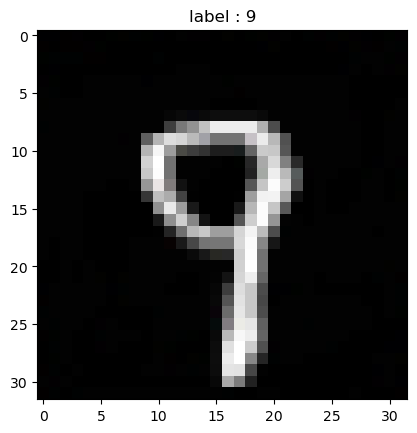

In [131]:
for img_batch, label_batch in adv_test_set_mlp_std.take(1):
    img = np.array(img_batch)
    label = np.argmax(label_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])
    plt.title(f"label : {label}")

In [128]:
# Evaluate std models on original test set (standard test set)
_, std_test_acc_cnn_std = cnn_std.evaluate(test_dataset)
_, std_test_acc_mlp_std = mlp_std.evaluate(test_dataset)
_, std_test_acc_mobilenet_std = mobilenet_std.evaluate(test_dataset)
_, std_test_acc_resnet_std = resnet_std.evaluate(test_dataset)
_, std_test_densenet_std = densenet_std.evaluate(test_dataset)

print(f"CNN Std Test Accuracy: {std_test_acc_cnn_std:.4f}")
print(f"MLP Std Test Accuracy: {std_test_acc_mlp_std:.4f}")
print(f"MobileNet Std Test Accuracy: {std_test_acc_mobilenet_std:.4f}")
print(f"ResNet Std Test Accuracy: {std_test_acc_resnet_std:.4f}")
print(f"DenseNet Std Accuracy: {std_test_densenet_std:.4f}")

14/14 [==============================] - 1s 56ms/step - loss: 0.0528 - accuracy: 0.9866
CNN Std Test Accuracy: 0.9888
MLP Std Test Accuracy: 0.9688
MobileNet Std Test Accuracy: 0.9777
ResNet Std Test Accuracy: 0.9766
DenseNet Std Accuracy: 0.9866


In [100]:
# Evaluate std models on the adversarial test set
_, adv_test_acc_cnn_std = cnn_std.evaluate(adv_test_set_cnn_std)
_, adv_test_acc_mlp_std = mlp_std.evaluate(adv_test_set_mlp_std)
_, adv_test_acc_mobilenet_std = mobilenet_std.evaluate(adv_test_set_mobilenet_std)
_, adv_test_acc_resnet_std = resnet_std.evaluate(adv_test_set_resnet_std)
_, adv_test_densenet_std = densenet_std.evaluate(adv_test_set_densenet_std)

print(f"CNN Std Adv-Test Accuracy: {adv_test_acc_cnn_std:.4f}")
print(f"MLP Std Adv-Test Accuracy: {adv_test_acc_mlp_std:.4f}")
print(f"MobileNet Std Adv-Test Accuracy: {adv_test_acc_mobilenet_std:.4f}")
print(f"ResNet Std Adv-Test Accuracy: {adv_test_acc_resnet_std:.4f}")
print(f"DenseNet Std Adv-Accuracy: {adv_test_densenet_std:.4f}")

14/14 [==============================] - 10s 685ms/step - loss: 0.1316 - accuracy: 0.9688
CNN Std Adv-Test Accuracy: 0.9688
MLP Std Adv-Test Accuracy: 0.9453
MobileNet Std Adv-Test Accuracy: 0.9609
ResNet Std Adv-Test Accuracy: 0.9699
DenseNet Std Adv-Accuracy: 0.9688


In [101]:
std_test_acc_std = [std_test_acc_cnn_std, std_test_acc_mlp_std, std_test_acc_mobilenet_std, std_test_acc_resnet_std, std_test_densenet_std]
adv_test_acc_std = [adv_test_acc_cnn_std, adv_test_acc_mlp_std, adv_test_acc_mobilenet_std, adv_test_acc_resnet_std, adv_test_densenet_std]

In [102]:
#calculate robustness score  for standard models
# R = adv_test_acc_std/std_test_acc_std (i.e performance on adversarial test set / performance on standard test set)
model_names = ['CNN', 'MLP', 'MobileNet', 'ResNet', 'DenseNet']
robustness_scores_std = [adv / std for adv, std in zip(adv_test_acc_std, std_test_acc_std)]

for i, score in enumerate(robustness_scores_std):
    print(f"Robustness score for model {i+1}: {score:.4f}")

Robustness score for model 1: 0.9775
Robustness score for model 2: 0.9758
Robustness score for model 3: 0.9840
Robustness score for model 4: 0.9954
Robustness score for model 5: 0.9808


In [108]:
"""generate adversarial test set for adversarial models"""
adv_test_set_cnn_adv = generate_adversarial_test_dataset(test_dataset, cnn_adv)
adv_test_set_mlp_adv = generate_adversarial_test_dataset(test_dataset, mlp_adv)
adv_test_set_mobilenet_adv = generate_adversarial_test_dataset(test_dataset, mobilenet_adv)
adv_test_set_resnet_adv = generate_adversarial_test_dataset(test_dataset, resnet_adv)
adv_test_set_densenet_adv = generate_adversarial_test_dataset(test_dataset, densenet_adv)

In [109]:
# Evaluate adv models on standard test set
_, std_test_acc_cnn_adv = cnn_adv.evaluate(test_dataset)
_, std_test_acc_mlp_adv = mlp_adv.evaluate(test_dataset)
_, std_test_acc_mobilenet_adv = mobilenet_adv.evaluate(test_dataset)
_, std_test_acc_resnet_adv = resnet_adv.evaluate(test_dataset)
_, std_test_densenet_adv = densenet_adv.evaluate(test_dataset)

print(f"CNN Adv Test Accuracy: {std_test_acc_cnn_adv:.4f}")
print(f"MLP Adv Test Accuracy: {std_test_acc_mlp_adv:.4f}")
print(f"MobileNet AdvTest Accuracy: {std_test_acc_mobilenet_adv:.4f}")
print(f"ResNet Adv Test Accuracy: {std_test_acc_resnet_adv:.4f}")
print(f"DenseNet Adv Accuracy: {std_test_densenet_adv:.4f}")


14/14 [==============================] - 1s 56ms/step - loss: 0.0386 - accuracy: 0.9877
CNN Adv Test Accuracy: 0.9855
MLP Adv Test Accuracy: 0.9732
MobileNet AdvTest Accuracy: 0.9810
ResNet Adv Test Accuracy: 0.9732
DenseNet Adv Accuracy: 0.9877


In [110]:
# Evaluate adv models on the adversarial test set
_, adv_test_acc_cnn_adv = cnn_std.evaluate(adv_test_set_cnn_adv)
_, adv_test_acc_mlp_adv = mlp_std.evaluate(adv_test_set_mlp_adv)
_, adv_test_acc_mobilenet_adv = mobilenet_std.evaluate(adv_test_set_mobilenet_adv)
_, adv_test_acc_resnet_adv = resnet_std.evaluate(adv_test_set_resnet_adv)
_, adv_test_densenet_adv = densenet_std.evaluate(adv_test_set_densenet_adv)

print(f"CNN Std Adv-Test Accuracy: {adv_test_acc_cnn_adv:.4f}")
print(f"MLP Std Adv-Test Accuracy: {adv_test_acc_mlp_adv:.4f}")
print(f"MobileNet Std Adv-Test Accuracy: {adv_test_acc_mobilenet_adv:.4f}")
print(f"ResNet Std Adv-Test Accuracy: {adv_test_acc_resnet_adv:.4f}")
print(f"DenseNet Std Adv-Accuracy: {adv_test_densenet_adv:.4f}")

14/14 [==============================] - 10s 695ms/step - loss: 0.0772 - accuracy: 0.9766
CNN Std Adv-Test Accuracy: 0.9743
MLP Std Adv-Test Accuracy: 0.9565
MobileNet Std Adv-Test Accuracy: 0.9732
ResNet Std Adv-Test Accuracy: 0.9710
DenseNet Std Adv-Accuracy: 0.9766


In [111]:
std_test_acc_adv = [std_test_acc_cnn_adv, std_test_acc_mlp_adv, std_test_acc_mobilenet_adv, std_test_acc_resnet_adv, std_test_densenet_adv]
adv_test_acc_adv = [adv_test_acc_cnn_adv, adv_test_acc_mlp_adv, adv_test_acc_mobilenet_adv, adv_test_acc_resnet_adv, adv_test_densenet_adv]

In [112]:
#calculate robustness score  for adversarial models

robustness_scores_adv = [adv / std for adv, std in zip(adv_test_acc_adv, std_test_acc_adv)]

for i, score in enumerate(robustness_scores_adv):
    print(f"Robustness score for model {i+1}: {score:.4f}")

Robustness score for model 1: 0.9887
Robustness score for model 2: 0.9828
Robustness score for model 3: 0.9920
Robustness score for model 4: 0.9977
Robustness score for model 5: 0.9887
